In [3]:
import sys
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader
from typing import Union, Tuple

import pickle as pk

from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

In [4]:
torch.cuda.is_available()

True

# Load the MNIST Dataset

In [5]:
#DataPath = r"D:\PatternRecognition_Data"
DataPath = "./"

train_data = datasets.MNIST(DataPath, train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=len(train_data))
batch = next(iter(train_loader))
x, y = batch
mean, std = torch.mean(x), torch.std(x)
transform = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
])

batch_size = 32
trainset = datasets.MNIST(root=DataPath, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.MNIST(root=DataPath, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [10]:
# 1875 batches
len(train_loader)

1875

In [ ]:
# Each batch containing 32 images of shape 28x28
next(iter(train_loader))[0].shape

torch.Size([32, 1, 28, 28])

# Exercise 1: Autoencoder Network Implementation

Implement an Autoencoder that encodes the MNIST dataset to a latent dimension of size m < 784. Use Tranposed Convolutions and/or Unpooling to solve this exercise. Train the Autoencoder and plot the reconstruction training loss. Plot 5 digits (of your choice) before and after reconstruction. Do this for two different latent dimension sizes.


In [24]:
class Autoencoder(nn.Module):
  def __init__(self, latent_width):
    # Initialize as subclass of nn.Module inheriting all its functions
    super(Autoencoder, self).__init__()
    encode = [nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
              nn.LeakyReLU(),
              nn.BatchNorm2d(16),
              nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
              nn.LeakyReLU(),
              nn.BatchNorm2d(32)]
    decode = [nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2, padding=0),
              nn.LeakyReLU(),
              nn.BatchNorm2d(16),
              nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2, padding=0),
              nn.LeakyReLU(),
              nn.BatchNorm2d(1)]
    self.encoder = nn.Sequential(*encode)
    self.encoder_end = nn.Linear(32 * 7 * 7, latent_width)
    self.decoder_start = nn.Linear(latent_width, 32 * 7 * 7)
    self.decoder = nn.Sequential(*decode)
                                           

  def forward(self, x):
    z = self.encoder(x)
    z = self.encoder_end(z.reshape([z.shape[0],-1]))
    y = self.decoder_start(z)
    y = self.decoder(y.reshape([y.shape[0],32,7,7]))
    return y

In [25]:
autoenc_model = Autoencoder(latent_width=100)
summary(autoenc_model, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
         LeakyReLU-2           [-1, 16, 14, 14]               0
       BatchNorm2d-3           [-1, 16, 14, 14]              32
            Conv2d-4             [-1, 32, 7, 7]           4,640
         LeakyReLU-5             [-1, 32, 7, 7]               0
       BatchNorm2d-6             [-1, 32, 7, 7]              64
            Linear-7                  [-1, 100]         156,900
            Linear-8                 [-1, 1568]         158,368
   ConvTranspose2d-9           [-1, 16, 14, 14]           2,064
        LeakyReLU-10           [-1, 16, 14, 14]               0
      BatchNorm2d-11           [-1, 16, 14, 14]              32
  ConvTranspose2d-12            [-1, 1, 28, 28]              65
        LeakyReLU-13            [-1, 1, 28, 28]               0
      BatchNorm2d-14            [-1, 1,

In [26]:
def train(
    model: nn.Module, 
    optimizer: optim.Optimizer, 
    data: Union[DataLoader, Tuple[DataLoader]], 
    max_epochs: int, 
    cuda=True):
    """
    Train a NN 'model' on 'data' in 'max_epochs' many epochs using 'optimizer' optimization method.
    """
  
    use_test = False
    if isinstance(data, DataLoader):
        train_loader = data
    elif isinstance(data, tuple):
        if len(data) == 2:
            train_loader, test_loader = data
            if not isinstance(train_loader, DataLoader):
                raise TypeError(f'Expected 1st entry of type DataLoader, but got {type(train_loader)}!')
            if not isinstance(test_loader, DataLoader):
                raise TypeError(f'Expected 2nd entry of type DataLoader, but got {type(test_loader)}!')
            use_test = True
        else:
            raise ValueError(f'Expected tuple of length 2, but got {len(data)}!')
  
    criterion = nn.MSELoss()
    losses = []
    model.train()
    batch_total = len(train_loader)

    for epoch in range(max_epochs):
        samples_total = 0
        samples_correct = 0
        for batch_idx, batch in enumerate(train_loader):
            x, y = batch
            if cuda:
                x, y = x.cuda(), y.cuda()
            output = model(x)
            loss = criterion(output, x)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            if batch_idx % 50 == 0:
                sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} Loss: {loss.item():.6f}')
    return losses

### Train with latent space size 100:

In [ ]:
autoenc_model_100 = Autoencoder(latent_width=100)
autoenc_model_100 = autoenc_model_100.cuda()
autoenc_optim_100 = optim.Adam(autoenc_model_100.parameters(), lr=1e-5)
autoenc_losses_100 = train(autoenc_model_100, autoenc_optim_100, (train_loader, test_loader), max_epochs=10)

Epoch: 9/10 Step: 1850/1875 Loss: 0.126405

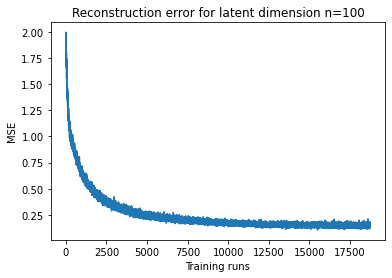

In [ ]:
fig, ax = plt.subplots()
ax.plot(autoenc_losses_100)
ax.set_title('Reconstruction error for latent dimension n=100')
ax.set_xlabel('Training runs')
ax.set_ylabel('MSE')
plt.show()

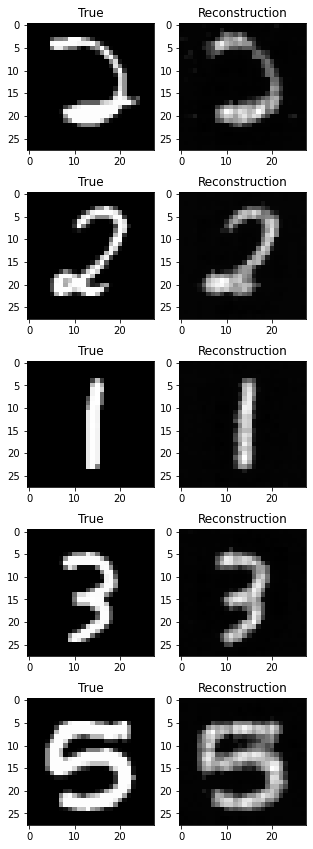

In [ ]:
x, y = next(iter(train_loader))
# img_block = autoenc_model.decoder(torch.rand(32,16,7,7))
img_block = autoenc_model_100(x[:5].cuda())

fig = plt.figure(figsize=(5, 15))
columns = 2
rows = 5
counter = 0
for x, img in zip(x[:5],img_block):
    img_new = img[0].detach().cpu().numpy()
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(x[0], cmap="gray")
    counter += 1
    plt.title("True")
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img_new, cmap="gray")
    plt.title("Reconstruction")
    counter += 1
plt.show()

### Train with latent space size 10:

In [ ]:
autoenc_model_10 = Autoencoder(latent_width=10)

autoenc_model_10 = autoenc_model_10.cuda()

autoenc_optim_10 = optim.Adam(autoenc_model_10.parameters(), lr=1e-5)

autoenc_losses_10 = train(autoenc_model_10, autoenc_optim_10, (train_loader, test_loader), max_epochs=10)

Epoch: 9/10 Step: 1850/1875 Loss: 0.397266

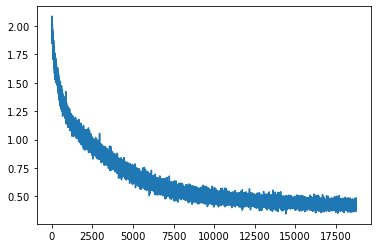

In [ ]:
fig, ax = plt.subplots()
ax.plot(autoenc_losses_10)
ax.set_title('Reconstruction error for latent dimension n=10')
ax.set_xlabel('Training runs')
ax.set_ylabel('MSE')
plt.show()

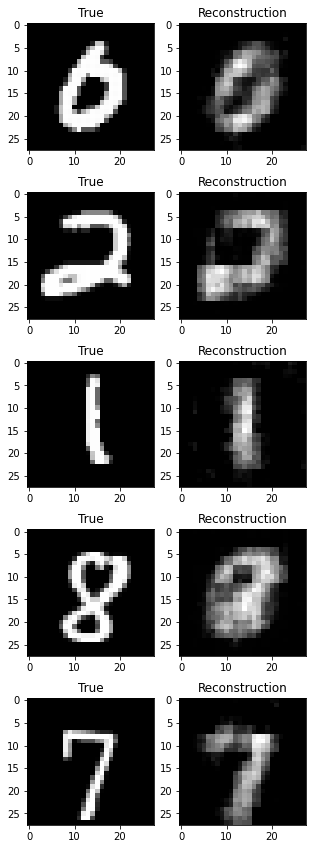

In [ ]:
x, y = next(iter(train_loader))
# img_block = autoenc_model.decoder(torch.rand(32,16,7,7))
img_block = autoenc_model_10(x[:5].cuda())

fig = plt.figure(figsize=(5, 15))
columns = 2
rows = 5
counter = 0
for x, img in zip(x[:5],img_block):
    img_new = img[0].detach().cpu().numpy()
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(x[0], cmap="gray")
    counter += 1
    plt.title("True")
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img_new, cmap="gray")
    plt.title("Reconstruction")
    counter += 1
plt.show()

### Result:
The Autoencoder with a latent space of lower dimension compression showed significantly worse image reconstructions than the Autoencode with a higher dimensional latent space!

# Exercise 2: Variational Autoencoder Network Implementation
Now that you have built an Autoencoder, it is time to implement a Variational Autoencoder. You can use the Autoencoder you trained in the previous exercise and adapt it for this exercise. Do not forget to use the reparametrization trick for sampling from Z-space. (30%)

(a) Train a Variational Autoencoder with latent dimension of size 2. Then, plot the digits where their associated position was in latent space similarly as explained in the lecture. (25%)

(b) Plot the stdiance vector of the decoder for a single input as an image (in digit space; [3,28,28]). What is the interpretation of that? (25%)


In [128]:

class VAE(nn.Module):
  def __init__(self, latent_width):
    # Initialize as subclass of nn.Module inheriting all its functions
    super(VAE, self).__init__()
    encode = [nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
              nn.LeakyReLU(),
              nn.BatchNorm2d(16),
              nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
              nn.LeakyReLU(),
              nn.BatchNorm2d(32)]
    decode = [nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2, padding=0),
              nn.LeakyReLU(),
              nn.BatchNorm2d(16),
              nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2, padding=0),
              nn.LeakyReLU(),
              nn.BatchNorm2d(1)]
    self.encoder = nn.Sequential(*encode)
    self.encoder_end_mu = nn.Linear(32 * 7 * 7, latent_width)
    self.encoder_end_std = nn.Linear(32 * 7 * 7, latent_width)
    self.decoder_start = nn.Linear(latent_width, 32 * 7 * 7)
    self.decoder = nn.Sequential(*decode)
    self.decoder_end_mu = nn.Linear(1 * 28 * 28, 1 * 28 * 28)
    self.decoder_end_std = nn.Linear(1 * 28 * 28, 1 * 28 * 28)
                                       

  def forward(self, x):
    mu, std = self.encode_mean_std(x)
    mu2, std2 = self.decode_mean_std(mu, std)
    # here: return mu as reconstructed xhat
    # alternative: generate N(mu,sqrt(std)) and sample xhat
    return mu2


  def encode_mean_std(self, x):
    z = self.encoder(x)
    mu = self.encoder_end_mu(z.reshape([z.shape[0],-1]))
    std = self.encoder_end_std(z.reshape([z.shape[0],-1]))
    return mu, std


  def decode_mean_std(self, mu, std):
    # Reparametrization
    z = self.reparametrize(mu, std)
    # Decode
    y = self.decoder_start(z)
    y = self.decoder(y.reshape([-1,32,7,7]))
    mu2 = self.decoder_end_mu(y.reshape([y.shape[0],-1]))
    std2 = self.decoder_end_std(y.reshape([y.shape[0],-1]))
    return mu2, std2


  def reparametrize(self, mu, std):
     """
     :param mu: mean from the encoder's latent space
     :param std: standard devitation from the encoder's latent space
     """
     # Sample eps from normal distribution: `randn_like` as we need the same size
     eps = torch.randn_like(std) 
     # Sampling z from q(z|x) being a normal distribution N(mu, sqrt(std))
     return mu + (eps * std) 


In [129]:
vae_model = VAE(latent_width=2)
summary(vae_model, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
         LeakyReLU-2           [-1, 16, 14, 14]               0
       BatchNorm2d-3           [-1, 16, 14, 14]              32
            Conv2d-4             [-1, 32, 7, 7]           4,640
         LeakyReLU-5             [-1, 32, 7, 7]               0
       BatchNorm2d-6             [-1, 32, 7, 7]              64
            Linear-7                    [-1, 2]           3,138
            Linear-8                    [-1, 2]           3,138
            Linear-9                 [-1, 1568]           4,704
  ConvTranspose2d-10           [-1, 16, 14, 14]           2,064
        LeakyReLU-11           [-1, 16, 14, 14]               0
      BatchNorm2d-12           [-1, 16, 14, 14]              32
  ConvTranspose2d-13            [-1, 1, 28, 28]              65
        LeakyReLU-14            [-1, 1,

In [142]:
def reconstruction_loss(x, mu, std):
  """
  Implements reconstruction loss.
  """
  x = x.reshape([x.shape[0],-1])
  C = torch.sum(-0.5 * np.log(2*np.pi) + torch.log(torch.pow(std,2)))
  reconstruction_error = C + torch.sum(torch.pow(x - mu, 2) / torch.pow(std,2))
  return torch.mean(reconstruction_error)

def KL_divergence(mu, std):
  """
  Implements the Kullback-Leibler divergence.
  """
  KLD = 0.5 * torch.sum(1 + torch.log(torch.pow(std,2)) - torch.pow(mu, 2) - torch.pow(std,2))
  return torch.mean(KLD)

def train(model: nn.Module, optimizer: optim.Optimizer, data: Union[DataLoader, Tuple[DataLoader]], max_epochs: int, cuda=True):
    """
    Train a NN 'model' on 'data' in 'max_epochs' many epochs using 'optimizer' optimization method.
    """
  
    use_test = False
    if isinstance(data, DataLoader):
        train_loader = data
    elif isinstance(data, tuple):
        if len(data) == 2:
            train_loader, test_loader = data
            if not isinstance(train_loader, DataLoader):
                raise TypeError(f'Expected 1st entry of type DataLoader, but got {type(train_loader)}!')
            if not isinstance(test_loader, DataLoader):
                raise TypeError(f'Expected 2nd entry of type DataLoader, but got {type(test_loader)}!')
            use_test = True
        else:
            raise ValueError(f'Expected tuple of length 2, but got {len(data)}!')
  
    model.train()
    losses = []
    losses_KL = []
    losses_rec = []
    batch_total = len(train_loader)

    for epoch in range(max_epochs):
        samples_total = 0
        samples_correct = 0
        for batch_idx, batch in enumerate(train_loader):
            x, y = batch
            if cuda:
                x, y = x.cuda(), y.cuda()
            #optimizer.zero_grad()
            E_mu, E_std = model.encode_mean_std(x) 
            D_mu, D_std = model.decode_mean_std(E_mu, E_std) 

            loss1 = KL_divergence(E_mu, E_std)
            loss2 = reconstruction_loss(x, D_mu, D_std)
            loss = loss1 + loss2
            losses.append(loss.item())
            losses_KL.append(loss1.item())
            losses_rec.append(loss2.item())

            loss.backward()
            optimizer.step()


            if batch_idx % 50 == 0:
                sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} Loss: {loss.item():.6f}')
    return losses, losses_KL, losses_rec

In [145]:
vae_model = VAE(latent_width=2)
vae_model.cuda()
vae_optim = optim.Adam(vae_model.parameters(), lr=1e-4)
vae_losses = train(vae_model, vae_optim, (train_loader, test_loader), max_epochs=10)

Epoch: 9/10 Step: 1850/1875 Loss: 1749735808.000000

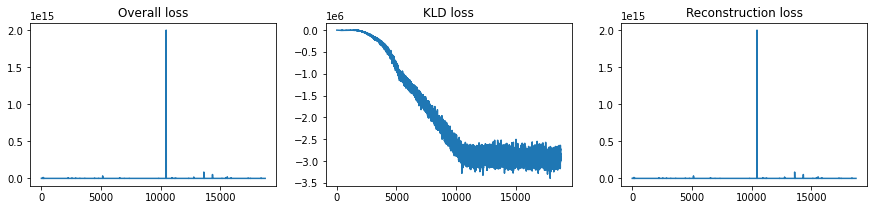

In [146]:
fig, ax = plt.subplots(1,3, figsize=(15,3))
ax[0].plot(vae_losses[0])
ax[0].set_title('Overall loss')
ax[1].plot(vae_losses[1])
ax[1].set_title('KLD loss')
ax[2].plot(vae_losses[2])
ax[2].set_title('Reconstruction loss')
plt.show()

# Questions
- @Paul: why in reconstruction error also take half of the weighted MSE part?